# Sarcasm Detector

Sarcasm is defined to be "the use of remarks that clearly mean the opposite of what they say, made in order to hurt someone's feelings or to criticize something in a humorous way" by The Cambridge Dictionary. Used for a varitey of purposes in the media, sarcasm can portray strong opinions and extreme perspectives of current events to provide comic relief and culturally-relevant dialogue.

Our objective in the following project will be to explore characteristics of our headline data overall, as well as in the context of sarcastic and non-sarcastic subsets. Furthermore, we will attempt to develop deep neural networks and other classifiers that provide accurate classification models for determining whether a given headline is sarcastic or not.

The dataset utilized in this project derives news headlines from two sources: (1) TheOnion for sarcastic articles, and (2) HuffPost for non-sarcastic articles.

This project and the subsequent models developed provide relevant information about how to distinguish between real news and fake news in a world increasingly characterized by mass amounts of news every second of every day. As our society becomes more and more polarized and partisan in our efforts to enact policies and reach solutions for the many issues that plague our world, it becomes increasingly necessary to sort out fact from fiction. Thus, further work of importance may include expanding these models and data exploration in attempts to determine the level of objectivity and bias in a given headline, somewhere on a scale from perfectly factual to perfectly sarcastic.

## Introduction

In order to conduct our exploration, we will utilize the OSEMN (obtain, scrub, explore, model, and analyze) data science framework. Sections are labeled accordingly and questions of relevance include:
- What proportion of articles are sarcastic? Non-sarcastic?
- How many total words are in our overall dataset? Total sarcastic words? Total non-sarcastic words?
- How many of these words are unique within our dataset? Unique sarcastic words? Unique non-sarcastic words?
- Which words are most common in headlines (including stopwords)? Most common in sarcastic headlines? Most common in non-sarcastic headlines?
- Which words, excluding stopwords, are most common in our three groups of headlines?
- With stopwords removed, which bigrams and trigrams are most populous in our headlines?
- How do these measures reflect cultural trends relevant to the time period?
- Using the Word2Vec vectorizer, how do initial classification models perform in differentiating between sarcastic and non-sarcastic headlines?
- Which types of RNNs can perform better than these intial models?
- What future work is possible based upon our findings in this project?

## Obtaining the Data

For this project, we obtained our dataset from Kaggle. The author of the dataset asserted the importance of a sarcasm dataset utilizing news headlines devoid of the excess noise present in many prior works drawing upon twitter for the presence of sarcasm. Additionally, news headlines are far less likely to contain grammatical and spelling errors, and do not necessitate additional context to tease out sarcastic elements. We pre-define two distinct groups by pulling sarcastic articles from the Onion and non-sarcastic asticles from Huffpost. The articles within our dataset come from actual news published within the past year, and thus reflect cultural trends important and relevant to our current society.

In [1]:
import pandas as pd
import numpy as np
np.random.seed(0)
import matplotlib.pyplot as plt
%matplotlib inline
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [2]:
df = pd.read_json('news-headlines-dataset-for-sarcasm-detection/Sarcasm_Headlines_Dataset.json', lines=True)
df.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0


In [3]:
df.shape

(26709, 3)

The dataset contains 26,709 articles total with three features for each: the article link, full headline, a binary indicator for whether or not the article is sarcastic.

## Scrubbing the Data

No missing data exists within our dataset. We are very lucky that the scrubbing process is not needed here! We will further transform our data below in prepartion for exploring the data.

## Exploring the Data

To begin exploring the data, we first divide the dataset into two groups: (1) sarcastic articles, and (2) non-sarcastic articles.

In [4]:
df_sarcastic = df[df['is_sarcastic']==1]
df_sarcastic.head()

,article_link,headline,is_sarcastic
2,https://local.theonion.com/mom-starting-to-fea...,mom starting to fear son's web series closest ...,1
3,https://politics.theonion.com/boehner-just-wan...,"boehner just wants wife to listen, not come up...",1
8,https://politics.theonion.com/top-snake-handle...,top snake handler leaves sinking huckabee camp...,1
15,https://entertainment.theonion.com/nuclear-bom...,nuclear bomb detonates during rehearsal for 's...,1
16,https://www.theonion.com/cosby-lawyer-asks-why...,cosby lawyer asks why accusers didn't come for...,1


In [5]:
df_not_sarcastic = df[df['is_sarcastic']==0]
df_not_sarcastic.head()

,article_link,headline,is_sarcastic
0,https://www.huffingtonpost.com/entry/versace-b...,former versace store clerk sues over secret 'b...,0
1,https://www.huffingtonpost.com/entry/roseanne-...,the 'roseanne' revival catches up to our thorn...,0
4,https://www.huffingtonpost.com/entry/jk-rowlin...,j.k. rowling wishes snape happy birthday in th...,0
5,https://www.huffingtonpost.com/entry/advancing...,advancing the world's women,0
6,https://www.huffingtonpost.com/entry/how-meat-...,the fascinating case for eating lab-grown meat,0


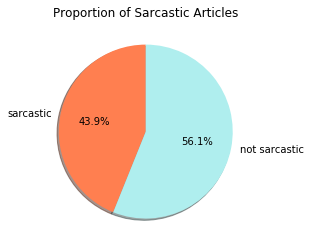

In [6]:
pie_slices = []
pie_slices.append(len(df_sarcastic)/len(df))
pie_slices.append(len(df_not_sarcastic)/len(df))
labels = ['sarcastic','not sarcastic']
plt.pie(pie_slices, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90, colors=['coral','paleturquoise'])
plt.title('Proportion of Sarcastic Articles')
plt.show()

**As the pie chart above displays, our dataset is comprised of 43.9% sarcastic articles and 56.1% non-sarcastic articles. This near-50/50 composition will aid in the validity of our classification models later on, as each disticn group has substanial data for us to draw upon.**

In [7]:
import numpy as np
from gensim.models import Word2Vec
from nltk import word_tokenize
from nltk.tokenize import TweetTokenizer

### Total Vocabulary

In preparation for further exploration and classification modeling later on, we set our data as the fully-tokenized headlines for all articles, and our target feature as the binary indicator of sarcasm for each.

In [30]:
pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
data = df['headline'].map(word_tokenize)

In [31]:
target = df['is_sarcastic']

In [32]:
data[:5]

0    [former, versace, store, clerk, sues, over, se...
1    [the, 'roseanne, ', revival, catches, up, to, ...
2    [mom, starting, to, fear, son, 's, web, series...
3    [boehner, just, wants, wife, to, listen, ,, no...
4    [j.k., rowling, wishes, snape, happy, birthday...
Name: headline, dtype: object

As the first five rows of our tokenized data display, the headlines are fully tokenized and ready for further data exploration.

In [4]:
import pandas as pd
total_tokens = [282582, 122043, 160539]
unique_tokens = [29291, 19405, 19624]
columns = ["All Headlines","Sarcasic","Non-Sarcastic"]
token_data = pd.DataFrame([total_tokens, unique_tokens],index=["Total Tokens","Unique Tokens"],columns=columns)
token_data

,All Headlines,Sarcasic,Non-Sarcastic
Total Tokens,282582,122043,160539
Unique Tokens,29291,19405,19624


**The table above summarizes the findings of the code in the remainder of this section, including a count of the total tokens and unique tokens for all headlines, sarcastic headlines, and non-sarcastic headlines.**

In [41]:
total_vocabulary = set(word for headline in data for word in headline)

In [42]:
len(total_vocabulary)
print("There are {} unique tokens in our dataset.".format(len(total_vocabulary)))

There are 29291 unique tokens in our dataset.


In [43]:
all_words = list(word for headline in data for word in headline)

In [44]:
len(all_words)
print("There are {} total tokens in our dataset.".format(len(all_words)))

There are 282582 total tokens in our dataset.


In [45]:
import nltk
from nltk import FreqDist

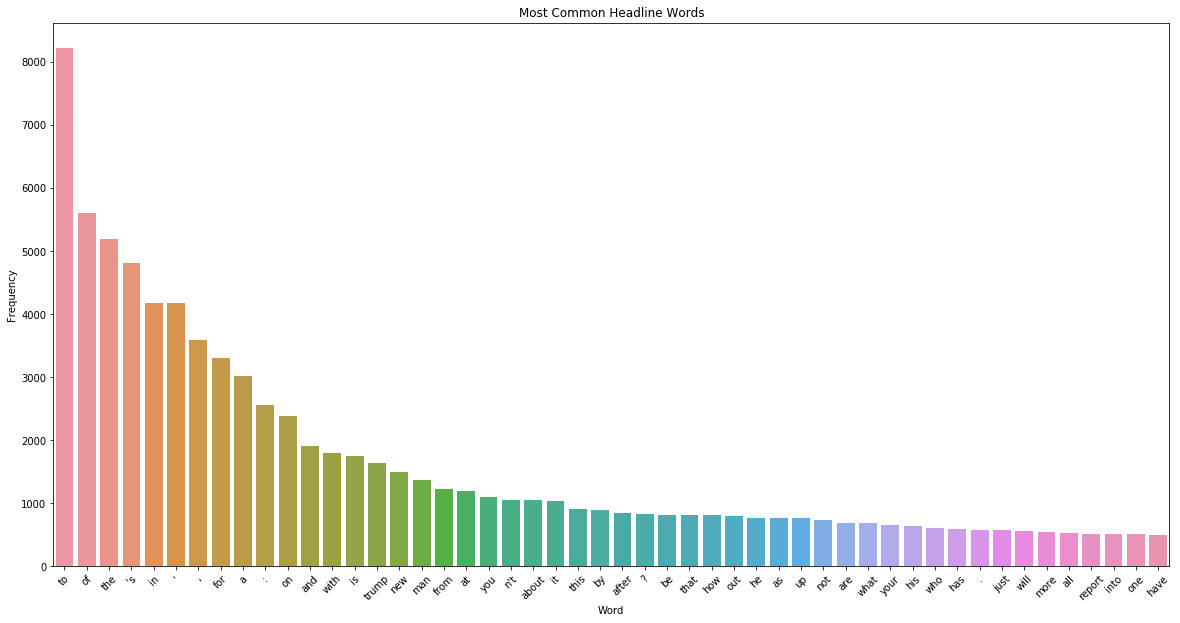

In [46]:
import seaborn as sns
data_freqdist = FreqDist(all_words)
data_most_common = data_freqdist.most_common(50)
words_to_graph = pd.DataFrame(data_most_common, columns=['word','count'])
plt.figure(figsize=(20,10))
sns.barplot(words_to_graph['word'],words_to_graph['count'])
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Most Common Headline Words')
plt.show()

The chart above displays the most common tokens in all the headlines. As stopwords have yet to be removed, many of the tokens are irrelvant to the content of our headlines and provide little insight into the cultural relevance of our data.

In [105]:
from nltk.corpus import stopwords
import string
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', "'s", "n't"]

all_words_stopped = [word for word in all_words if word not in stopwords_list]

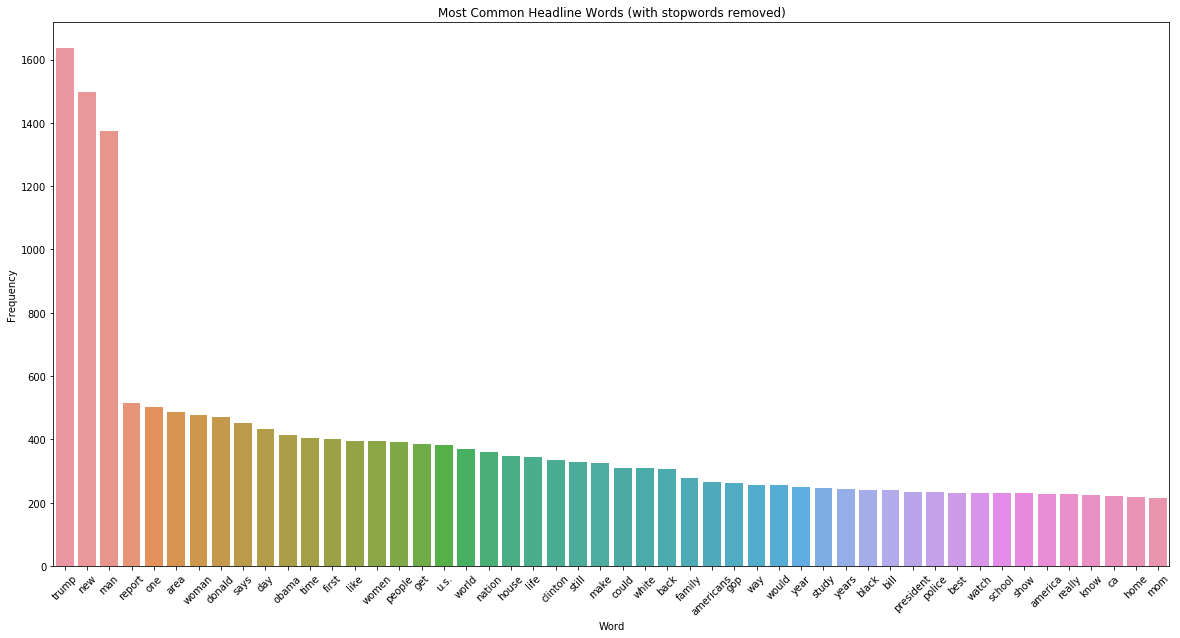

In [106]:
stopped_data_freqdist = FreqDist(all_words_stopped)
stopped_data_most_common = stopped_data_freqdist.most_common(50)
stopped_words_to_graph = pd.DataFrame(stopped_data_most_common, columns=['word','count'])
plt.figure(figsize=(20,10))
sns.barplot(stopped_words_to_graph['word'],stopped_words_to_graph['count'])
plt.xlabel('Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Most Common Headline Words (with stopwords removed)')
plt.show()

**With stopwords removed, the most common headline words provide much more insight into the content of headlines in recent news. Some insights of particular interest:**
- Unsurprisingly, "trump" dominates the headlines, with over 1600 mentions throughout all ~26000 headlines; as a single headline is unlikely to mention his name more than once, "trump" is present in nearly 6% of all headlines!
- "man" is mentioned approximately 3x as frequently "woman", a clear indicator of the gender bias present still prevalent across our society.
- Though a now-former president, "obama" appears over 400 times.
- "clinton" also appears around 400 times.
- "white" appears more freqently than "black" by approximately 100 occurrences.

### Sarcastic Words

In [33]:
sarc_data = df_sarcastic['headline'].map(word_tokenize)

In [34]:
total_sarc_vocabulary = set(word for headline in sarc_data for word in headline)

In [37]:
len(total_sarc_vocabulary)
print("There are {} unique tokens from sarcastic articles in our dataset.".format(len(total_sarc_vocabulary)))

There are 19405 unique tokens from sarcastic articles in our dataset.


In [38]:
all_sarc_words = list(word for headline in sarc_data for word in headline)

In [39]:
len(all_sarc_words)
print("There are {} total tokens in our sarcastic articles.".format(len(all_sarc_words)))

There are 122043 total tokens in our sarcastic articles.


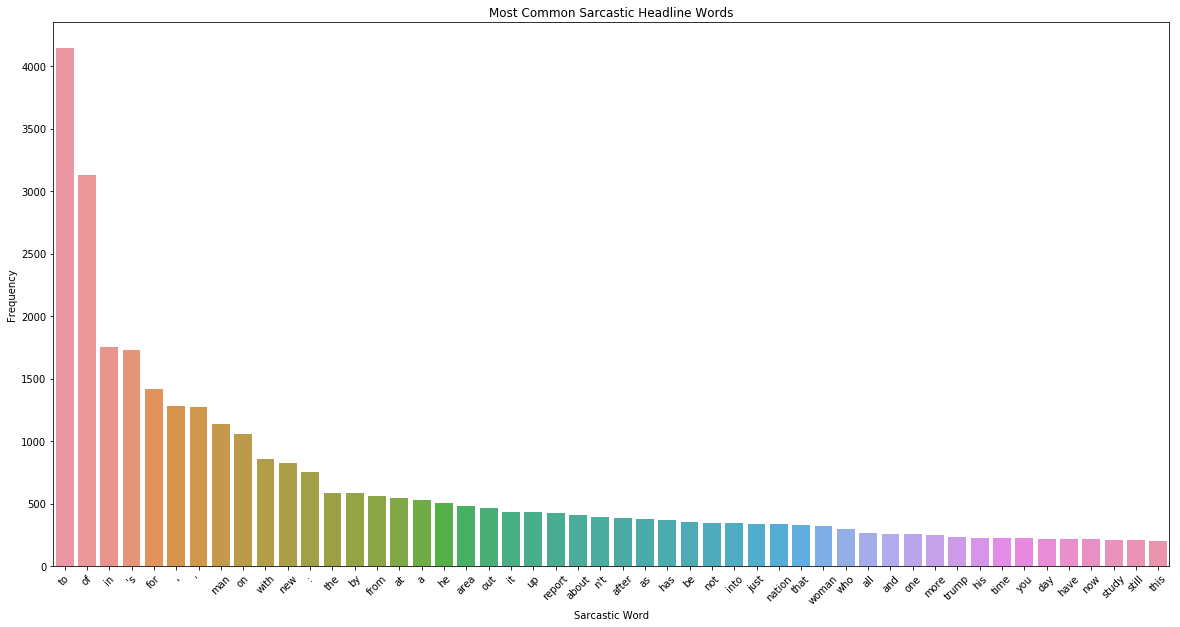

In [47]:
sarc_data_freqdist = FreqDist(all_sarc_words)
sarc_data_most_common = sarc_data_freqdist.most_common(50)
sarc_words_to_graph = pd.DataFrame(sarc_data_most_common, columns=['word','count'])
plt.figure(figsize=(20,10))
sns.barplot(sarc_words_to_graph['word'],sarc_words_to_graph['count'])
plt.xlabel('Sarcastic Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Most Common Sarcastic Headline Words')
plt.show()

We notice the same trend in top sarcastic words, without stopwords removed, with little to no relevant information.

In [127]:
all_sarc_words_stopped = [word for word in all_sarc_words if word not in stopwords_list]

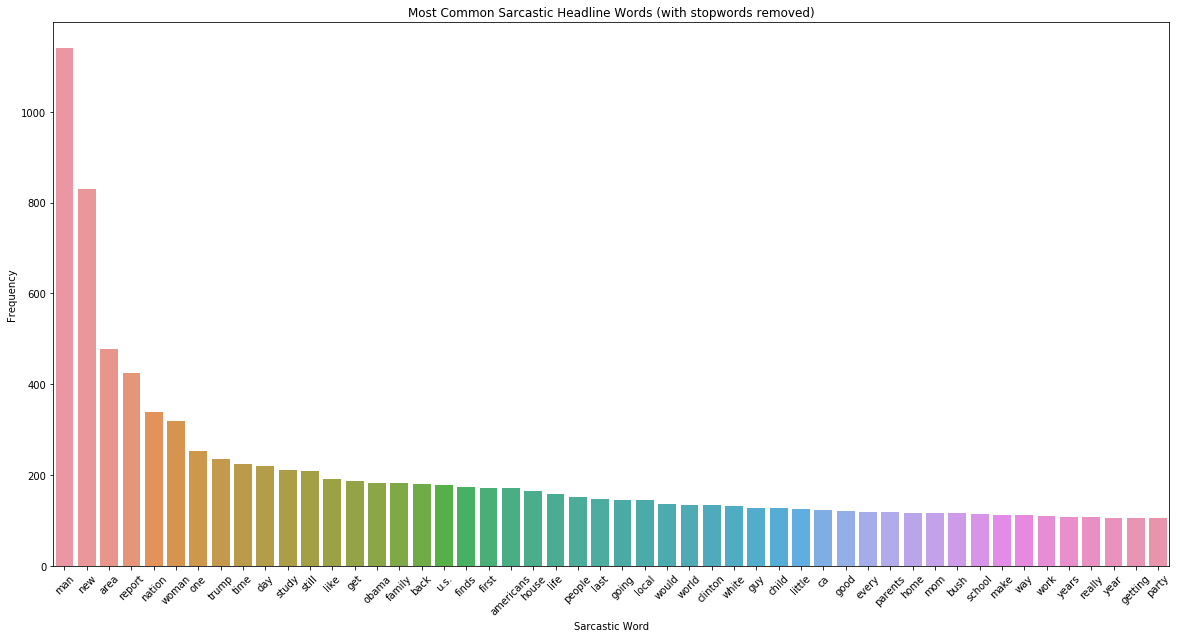

In [128]:
stopped_sarc_data_freqdist = FreqDist(all_sarc_words_stopped)
stopped_sarc_data_most_common = stopped_sarc_data_freqdist.most_common(50)
stopped_sarc_words_to_graph = pd.DataFrame(stopped_sarc_data_most_common, columns=['word','count'])
plt.figure(figsize=(20,10))
sns.barplot(stopped_sarc_words_to_graph['word'],stopped_sarc_words_to_graph['count'])
plt.xlabel('Sarcastic Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Most Common Sarcastic Headline Words (with stopwords removed)')
plt.show()

**Our chart above indicates the words "man", "new", "area", and "report" dominate our sarcastic headlines, all with over 400 occurrences. All these words indicate a certain vagueness present in much of sarcasm that alludes to particular cultural trends or issues, but avoids pointing the finger directly at any person in particular. That being said, "trump", "obama", and "clinton" appear to be the butt of many jokes in recent sarcasm, as their names specifically appear the most within our sarcastic data.**

### Non-Sarcastic Words

In [53]:
nonsarc_data = df_not_sarcastic['headline'].map(word_tokenize)

In [54]:
total_nonsarc_vocabulary = set(word for headline in nonsarc_data for word in headline)

In [55]:
len(total_nonsarc_vocabulary)
print("There are {} unique tokens from non-sarcastic articles in our dataset.".format(len(total_nonsarc_vocabulary)))

There are 19624 unique tokens from non-sarcastic articles in our dataset.


In [56]:
all_nonsarc_words = list(word for headline in nonsarc_data for word in headline)

In [57]:
len(all_nonsarc_words)
print("There are {} total tokens in our non-sarcastic articles.".format(len(all_nonsarc_words)))

There are 160539 total tokens in our non-sarcastic articles.


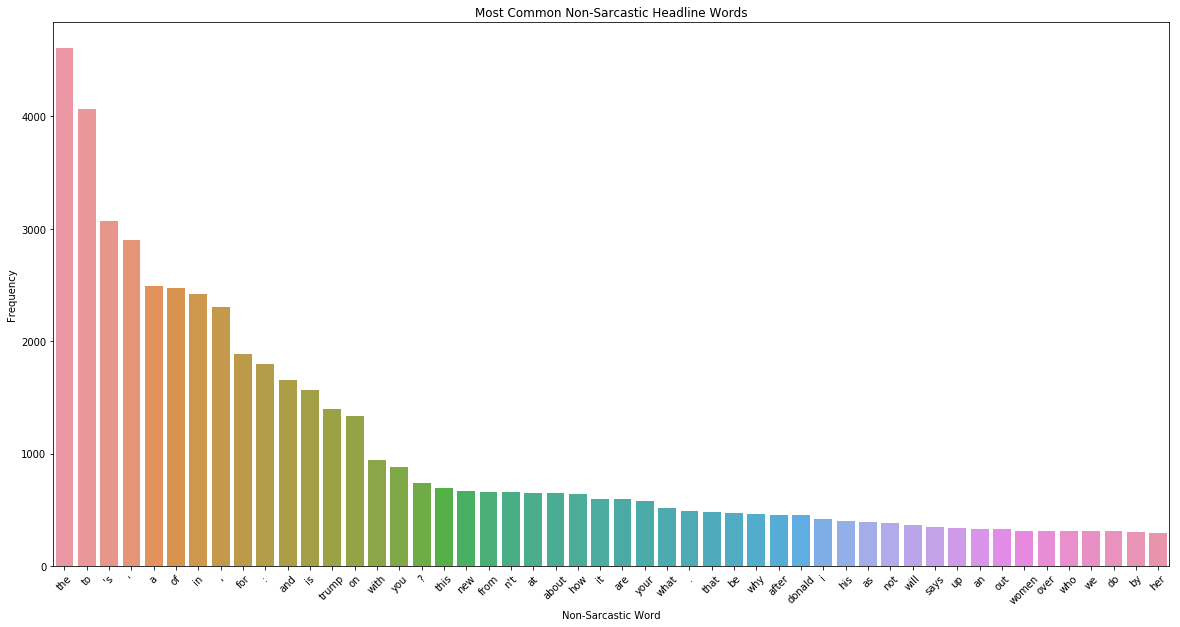

In [58]:
nonsarc_data_freqdist = FreqDist(all_nonsarc_words)
nonsarc_data_most_common = nonsarc_data_freqdist.most_common(50)
nonsarc_words_to_graph = pd.DataFrame(nonsarc_data_most_common, columns=['word','count'])
plt.figure(figsize=(20,10))
sns.barplot(nonsarc_words_to_graph['word'],nonsarc_words_to_graph['count'])
plt.xlabel('Non-Sarcastic Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Most Common Non-Sarcastic Headline Words')
plt.show()

In [135]:
all_nonsarc_words_stopped = [word for word in all_nonsarc_words if word not in stopwords_list]

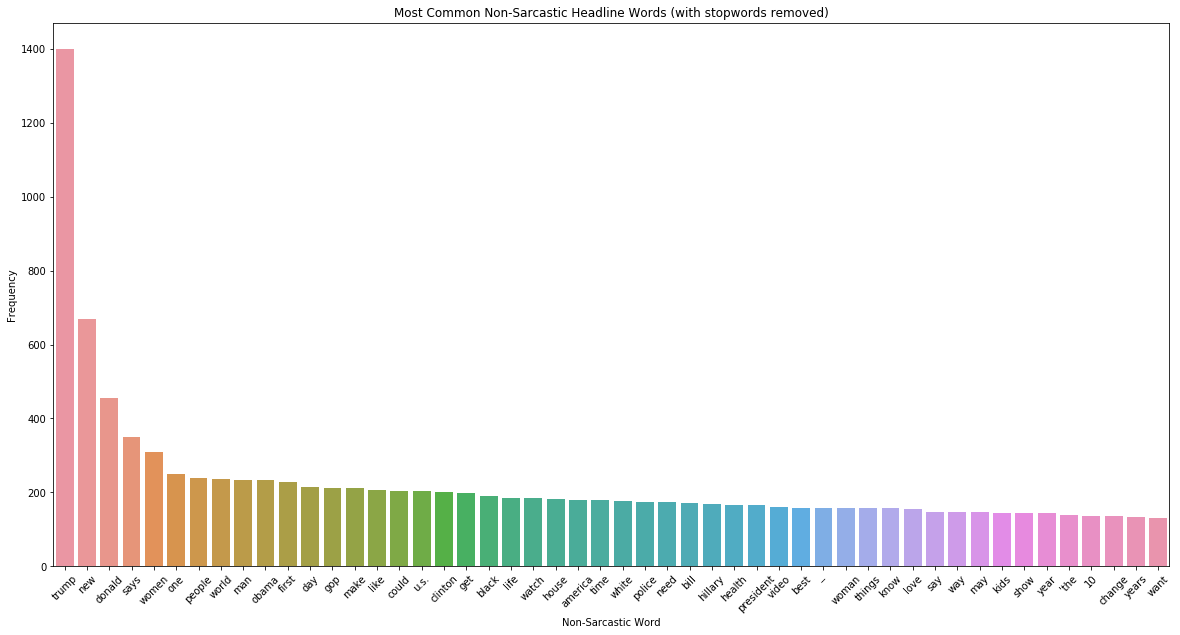

In [136]:
stopped_nonsarc_data_freqdist = FreqDist(all_nonsarc_words_stopped)
stopped_nonsarc_data_most_common = stopped_nonsarc_data_freqdist.most_common(50)
stopped_nonsarc_words_to_graph = pd.DataFrame(stopped_nonsarc_data_most_common, columns=['word','count'])
plt.figure(figsize=(20,10))
sns.barplot(stopped_nonsarc_words_to_graph['word'],stopped_nonsarc_words_to_graph['count'])
plt.xlabel('Non-Sarcastic Word')
plt.xticks(rotation=45)
plt.ylabel('Frequency')
plt.title('Most Common Non-Sarcastic Headline Words (with stopwords removed)')
plt.show()

**Our chart for the most common non-sarcastic headline words display results similar to that of our overall headline tokens. "trump" emerges even more clearly as the dominant topic in real headline news in 2018 and into 2019. "obama" and "clinton" (as well as "hillary") appear relatively frequently again. In real new headlines, without the large number of occurences of "man" in sarcastic headlines, "women" appears more frequently than references to men. Other tokens of interest that reflect key cultural trends as of late include "gap", "house", "bill", "police", and "change".**

In the next two sections, we will explore bigrams and trigrams in attempts to discover in greater trends within the importance of particular word associations.

### Bigrams

In [107]:
from nltk.collocations import *
bigram_measures = nltk.collocations.BigramAssocMeasures()

In [108]:
headline_finder = BigramCollocationFinder.from_words(all_words_stopped)

In [113]:
headline_scored = headline_finder.score_ngrams(bigram_measures.raw_freq)

In [114]:
headline_scored[:50]

[(('donald', 'trump'), 0.0024154205533219977),
 (('area', 'man'), 0.0013613225486924418),
 (('white', 'house'), 0.0009481585066768368),
 (('hillary', 'clinton'), 0.0009428615317792009),
 (('supreme', 'court'), 0.0005985581634328635),
 (('new', 'york'), 0.0005932611885352276),
 (('study', 'finds'), 0.0005826672387399556),
 (('bernie', 'sanders'), 0.0004131640420156049),
 (('climate', 'change'), 0.0003813821926297891),
 (('high', 'school'), 0.00036549126793688125),
 (('health', 'care'), 0.0003548973181416093),
 (('introduces', 'new'), 0.0003337094185510655),
 (('pope', 'francis'), 0.0003337094185510655),
 (('north', 'korea'), 0.0003284124436534295),
 (('ted', 'cruz'), 0.00031252151896052165),
 (('morning', 'email'), 0.0002966305942676138),
 (('paul', 'ryan'), 0.00028603664447234185),
 (('need', 'know'), 0.000270145719779434),
 (('area', 'woman'), 0.00025955176998416205),
 (('new', 'study'), 0.00023306689549598225),
 (('taylor', 'swift'), 0.00023306689549598225),
 (('mike', 'pence'), 0.00

**The list above displays the 50 most common bigrams throughout all news headlines, alongside the raw frequency measure. Below, we will convert the relative frequency to more user-friendly measure by multiplying the list by 10000 and graphing the results, although the ordered list of bigrams will remain unchanged. We will utilize the same process throughout the remainder of this section and the next, for sarcastic and non-sarcastic headlines as well.**

In [121]:
bigrams_df = pd.DataFrame(headline_scored, columns=['word','frequency'])
bigrams_df.frequency = bigrams_df.frequency*10000
bigrams_df.head()

,word,frequency
0,"(donald, trump)",24.154206
1,"(area, man)",13.613225
2,"(white, house)",9.481585
3,"(hillary, clinton)",9.428615
4,"(supreme, court)",5.985582


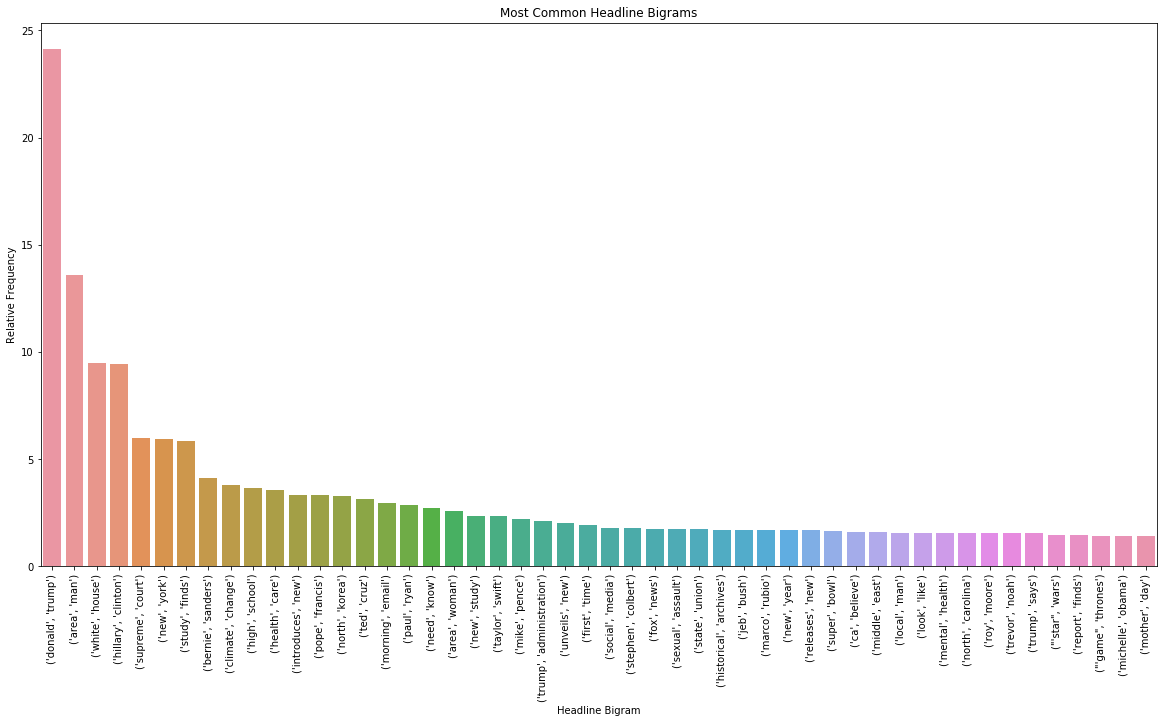

In [126]:
bigrams_tograph = bigrams_df[:50]
plt.figure(figsize=(20,10))
sns.barplot(bigrams_tograph['word'],bigrams_tograph['frequency'])
plt.xlabel('Headline Bigram')
plt.xticks(rotation=90)
plt.ylabel('Relative Frequency')
plt.title('Most Common Headline Bigrams')
plt.show()

**Across all headlines, we notice the following remarkable trends:**
- "donald trump" appears most frequently; while we as American citizens witness the immense presece of news about our current president on a daily basis, the dominance of his name reflected within the data is truly baffling.
- The following bigrams reflect important current political trends (listed in order of frequency): "white house", "hillary clinton, "supreme court", "bernie sanders", "ted cruz", "paul ryan", "mike pence", "trump administration", "fox news", "jeb bush", "marco rubio", and "michelle obama".
- Key social issues: "climate change", "health care", "sexual assault", and "mental health"
- Cultural trends: "taylor swift", "social media", "super bowl", "star wars", and "game thrones"
- Places of interest: "new york", "north korea", "middle east', "north carolina"

**While I identified these categories and lists using my best judgment, other methods of classifying these bigrams are welcome. However, it appears that political themes dominate our new headlines, with several key social issues emerging as most frequent. This may be skewed by the news source, as HuffPost is much more likely to cover political issues than those of pop culture. However, despite that bias, Taylor Swift still appears in the top half of the list, indicating her dominance in our cultural arena, at least during the time at which these article headlines were obtained. The places mentioned in our list indicate important trends within 21st century foreign policy, as our country continues to focus substantially on our relationship with North Korea and the Middle East. Domestically, New York and North Carolina emerge as epicenters of political and social relevance (on both sides of our political lines), as they have for much of the past decade. Below, it will be interesting to see which of the above bigrams fall under sarcastic and non-sarcastic headlines, or potentially both.**

In [129]:
sarc_headline_finder = BigramCollocationFinder.from_words(all_sarc_words_stopped)

In [130]:
sarc_headline_scored = sarc_headline_finder.score_ngrams(bigram_measures.raw_freq)

In [131]:
sarc_headline_scored[:50]

[(('area', 'man'), 0.0029602838186509398),
 (('study', 'finds'), 0.0011864172502764466),
 (('white', 'house'), 0.0010712311094729081),
 (('introduces', 'new'), 0.000702635458901585),
 (('area', 'woman'), 0.0005644120899373387),
 (('new', 'study'), 0.0004607445632141541),
 (('supreme', 'court'), 0.0004377073350534464),
 (('hillary', 'clinton'), 0.0004261887209730925),
 (('unveils', 'new'), 0.0004261887209730925),
 (('high', 'school'), 0.00041467010689273865),
 (('pope', 'francis'), 0.0003801142646516771),
 (('historical', 'archives'), 0.00036859565057132326),
 (('releases', 'new'), 0.00034555842241061553),
 (('local', 'man'), 0.0003340398083302617),
 (('ca', 'believe'), 0.00032252119424990786),
 (('paul', 'ryan'), 0.00029948396608920014),
 (('report', 'finds'), 0.00027644673792849247),
 (('area', 'dad'), 0.00025340950976778475),
 (('new', 'york'), 0.00024189089568743088),
 (('state', 'union'), 0.00024189089568743088),
 (('ca', 'wait'), 0.00023037228160707705),
 (('one', 'day'), 0.000230

In [140]:
sarc_bigrams_df = pd.DataFrame(sarc_headline_scored, columns=['word','frequency'])
sarc_bigrams_df.frequency = sarc_bigrams_df.frequency*10000
sarc_bigrams_df.head()

,word,frequency
0,"(area, man)",29.602838
1,"(study, finds)",11.864173
2,"(white, house)",10.712311
3,"(introduces, new)",7.026355
4,"(area, woman)",5.644121


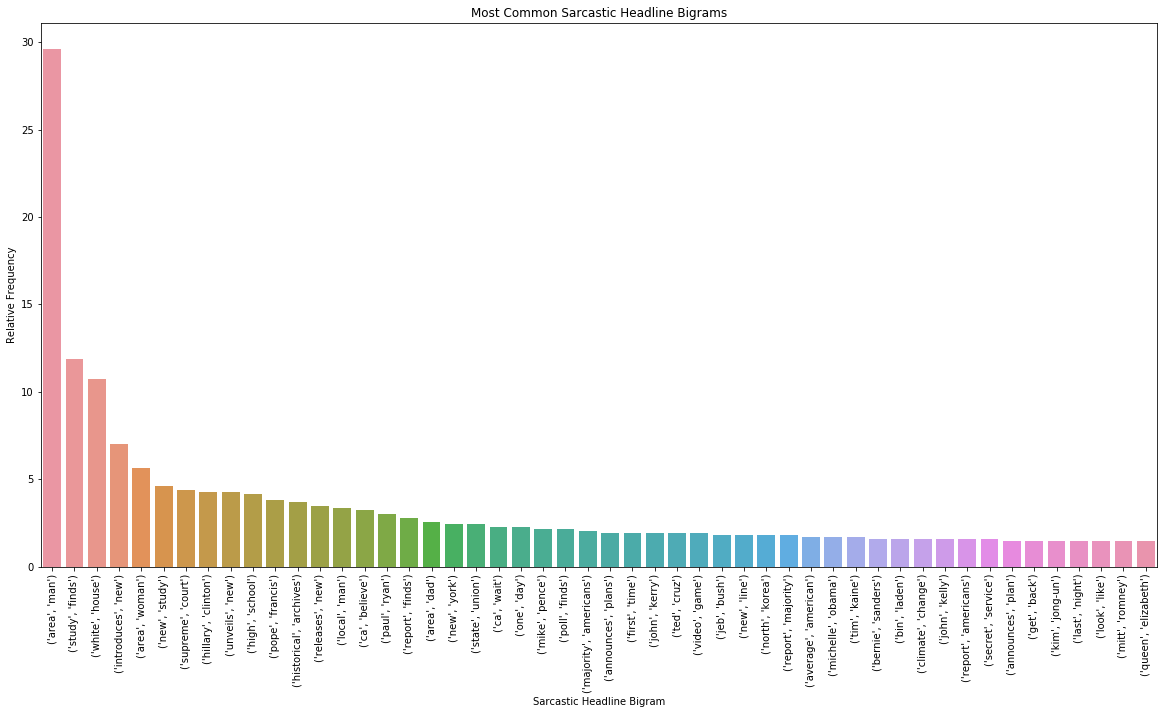

In [141]:
sarc_bigrams_tograph = sarc_bigrams_df[:50]
plt.figure(figsize=(20,10))
sns.barplot(sarc_bigrams_tograph['word'],sarc_bigrams_tograph['frequency'])
plt.xlabel('Sarcastic Headline Bigram')
plt.xticks(rotation=90)
plt.ylabel('Relative Frequency')
plt.title('Most Common Sarcastic Headline Bigrams')
plt.show()

**In sarcastic headlines, the following bigrams emerge as most insightful:**
- Political trends: "white house", "supreme court", "hillary clinton", "pope francis", "paul ryan", "mike pence", "john kerry", "ted cruz", "jeb bush", michelle obama", "tim kaine", "bernie sanders", "bin laden", "john kelly", "secret service", "kim jong-un", "mitt romney", and "queen elizabeth".
- Common sarcastic tropes: "area man", "study finds", "introduces new", "area woman", "new study", "unveils new", "releases new", "local man", "report finds", "area dad", "poll finds", "majority americans", "announces plans", "first time", "new line", "average american", "report majority", "report americans", "last night"
- Social/Cultural trends: "video game", "climate change"
- Places of importance: "new york", "north korea"

**Many of the same bigrams appear in our sarcastic headlines as in our overall headlines dataset. Within the list of politically-relevant bigrams, many minor political figures appear that (in my opinion) would otherwise be absent from the real media. However, I expect that some bigrams for people in sarcastic articles will also appear in the list of bigrams for real news, including Hillary Clinton, Bernie Sanders, Ted Cruz, and others important within the non-sarcastic news headlines of recent years.**

**The list of common sarcastic tropes sheds light on the nature of satire, particularly within the Onion. Most of these bigrams represent a vague generality that allows the headlines to be more relateable and applicable to a wide variety of people. They avoid focusing on a specifc place or person in order to instead illuminate specific cultural, political, and social trends that may be relatable to the vast majority of Americans, despite our differences in geographic area, political leanings, or educational background. Many of these bigrams emphasize the hyperpole used in satire, with the words "new", "majority", and "average" appearing many times. The satirical certianty of the Onion emerges within the tokens "study", "poll", and "report". These common themes weave themselves throughout the majority of satire, and coupled with references to widely-known key political figures and social issues, sets their newspaper up for success as a related source for a diverse audience.**



In [137]:
nonsarc_headline_finder = BigramCollocationFinder.from_words(all_nonsarc_words_stopped)

In [138]:
nonsarc_headline_scored = nonsarc_headline_finder.score_ngrams(bigram_measures.raw_freq)

In [139]:
nonsarc_headline_scored[:50]

[(('donald', 'trump'), 0.004354179129360309),
 (('hillary', 'clinton'), 0.0013827460748644222),
 (('new', 'york'), 0.000892410587323847),
 (('white', 'house'), 0.0008433770385697895),
 (('supreme', 'court'), 0.0007355032313108629),
 (('bernie', 'sanders'), 0.0006276294240519364),
 (('health', 'care'), 0.0005785958752978788),
 (('climate', 'change'), 0.0005687891655470673),
 (('morning', 'email'), 0.0005491757460454443),
 (('need', 'know'), 0.0005001421972913868),
 (('north', 'korea'), 0.00045110864853732923),
 (('ted', 'cruz'), 0.0004118818095340832),
 (('high', 'school'), 0.0003236214217767797),
 (('stephen', 'colbert'), 0.0003236214217767797),
 (('taylor', 'swift'), 0.00030400800227515666),
 (('trump', 'administration'), 0.00030400800227515666),
 (('pope', 'francis'), 0.00029420129252434514),
 (('new', 'year'), 0.00028439458277353363),
 (('sexual', 'assault'), 0.00028439458277353363),
 (('trevor', 'noah'), 0.00028439458277353363),
 (('paul', 'ryan'), 0.00027458787302272217),
 (('fox'

In [142]:
nonsarc_bigrams_df = pd.DataFrame(nonsarc_headline_scored, columns=['word','frequency'])
nonsarc_bigrams_df.frequency = nonsarc_bigrams_df.frequency*10000
nonsarc_bigrams_df.head()

,word,frequency
0,"(donald, trump)",43.541791
1,"(hillary, clinton)",13.827461
2,"(new, york)",8.924106
3,"(white, house)",8.433770
4,"(supreme, court)",7.355032


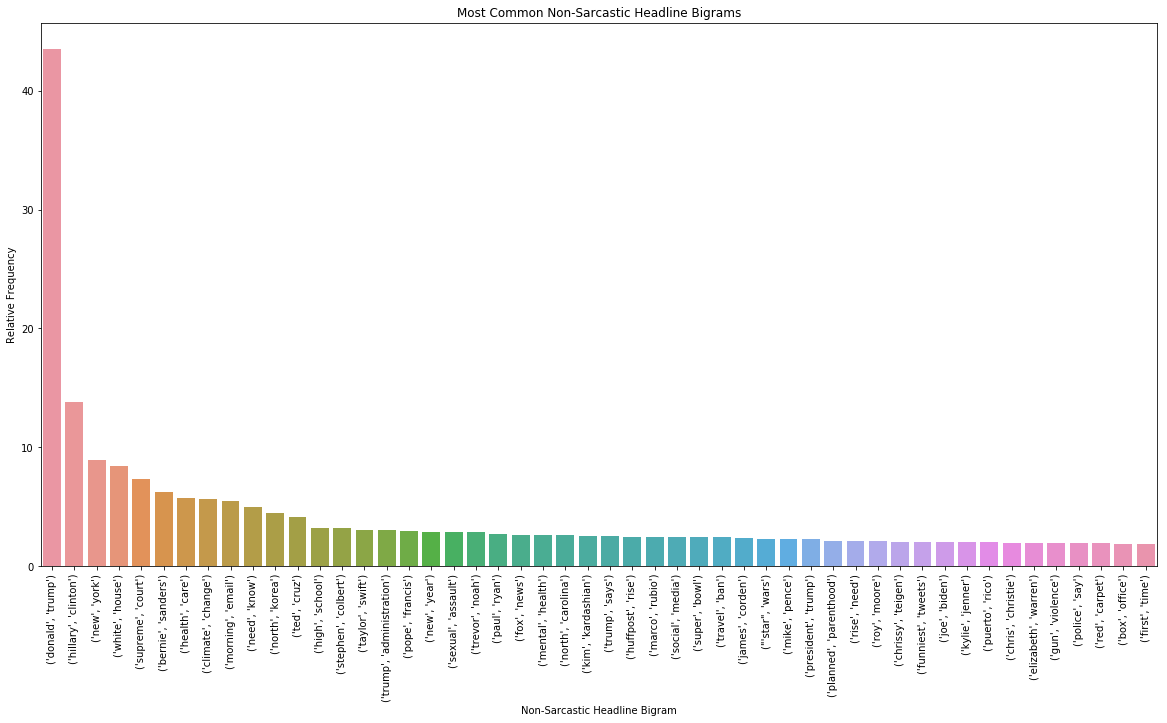

In [143]:
nonsarc_bigrams_tograph = nonsarc_bigrams_df[:50]
plt.figure(figsize=(20,10))
sns.barplot(nonsarc_bigrams_tograph['word'],nonsarc_bigrams_tograph['frequency'])
plt.xlabel('Non-Sarcastic Headline Bigram')
plt.xticks(rotation=90)
plt.ylabel('Relative Frequency')
plt.title('Most Common Non-Sarcastic Headline Bigrams')
plt.show()

**In real news headlines, the following bigrams appear most frequently:**
- Political trends: "donald trump", "hillary clinton", "white house", "supreme court", "bernie sanders", "ted cruz", "trump administration", "pope francis", "steven colbert", "trevor noah", "paul ryan", "fox news", "marco rubio", "mike pence", "roy moore", "joe biden", "chris christie", "elizabeth warren" (my girl woop woop!),
- Places of interest: "new york", "north korea", "north carolina", "puerto rico"
- Key social issues: "health care", "climate change", "sexual assault", "mental health", "travel ban", "planned parenthood", "gun violence"
- Cultural trends: "taylor swift", "kim kardashian", "social media", "super bowl", "james corden", "star wars", "chrissy teigen", "funniest tweets", "kylie jenner", "red carpet", "box office"

**Much of the same trends emerge here in real news as we observed in the bigrams for overall headlines. Key differences or additions include:**
- Smaller key political figures that had brief surges within the news due to key political events, or in the case of Elizabeth Warren, those who have since the of these headlines obtained a much greater news presence.
- Additional key social issues including planned parenthood, the travel ban, and gun violence
- More pop culture figures such as Kim Kardashian, Kylie Jenner (rise and shine!), Chrissy Teigen, and references to awards shows (red carpet, box office)
- The substanial impact of social media (also "funniest tweets") on the cultural character of our society

### Trigrams

The list following the code below displays the 50 most common trigrams throughout all news headlines. Many of the same trends emerge within the most common trigrams as those that we observed within the bigram section above. Thus in this section, we will focus primarily on the key differences and addtions to the analysis presented above.

In [144]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()

In [145]:
headline_finder_tri = TrigramCollocationFinder.from_words(all_words_stopped)

In [146]:
headline_scored_tri = headline_finder_tri.score_ngrams(trigram_measures.raw_freq)

In [147]:
headline_scored_tri[:50]

[(('new', 'study', 'finds'), 0.0001748001716219867),
 (('huffpost', 'rise', 'need'), 0.00011653344774799113),
 (('rise', 'need', 'know'), 0.00011653344774799113),
 (('new', 'york', 'times'), 8.475159836217536e-05),
 (('friday', 'morning', 'email'), 7.94546234645394e-05),
 (('funniest', 'tweets', 'women'), 7.94546234645394e-05),
 (('new', 'york', 'city'), 7.94546234645394e-05),
 (('tweets', 'women', 'week'), 7.94546234645394e-05),
 (('donald', 'trump', 'says'), 6.886067366926748e-05),
 (('everything', 'need', 'know'), 6.886067366926748e-05),
 (('health', 'care', 'bill'), 6.886067366926748e-05),
 (('martin', 'luther', 'king'), 6.356369877163151e-05),
 (('women', 'business', 'q'), 6.356369877163151e-05),
 (('friday', 'talking', 'points'), 5.826672387399556e-05),
 (('george', 'w.', 'bush'), 5.826672387399556e-05),
 (('talking', 'points', '--'), 5.826672387399556e-05),
 (('thursday', 'morning', 'email'), 5.826672387399556e-05),
 (("'american", 'horror', 'story'), 5.29697489763596e-05),
 (("

In [148]:
trigrams_df = pd.DataFrame(headline_scored_tri, columns=['word','frequency'])
trigrams_df.frequency = trigrams_df.frequency*10000
trigrams_df.head()

,word,frequency
0,"(new, study, finds)",1.748002
1,"(huffpost, rise, need)",1.165334
2,"(rise, need, know)",1.165334
3,"(new, york, times)",0.847516
4,"(friday, morning, email)",0.794546


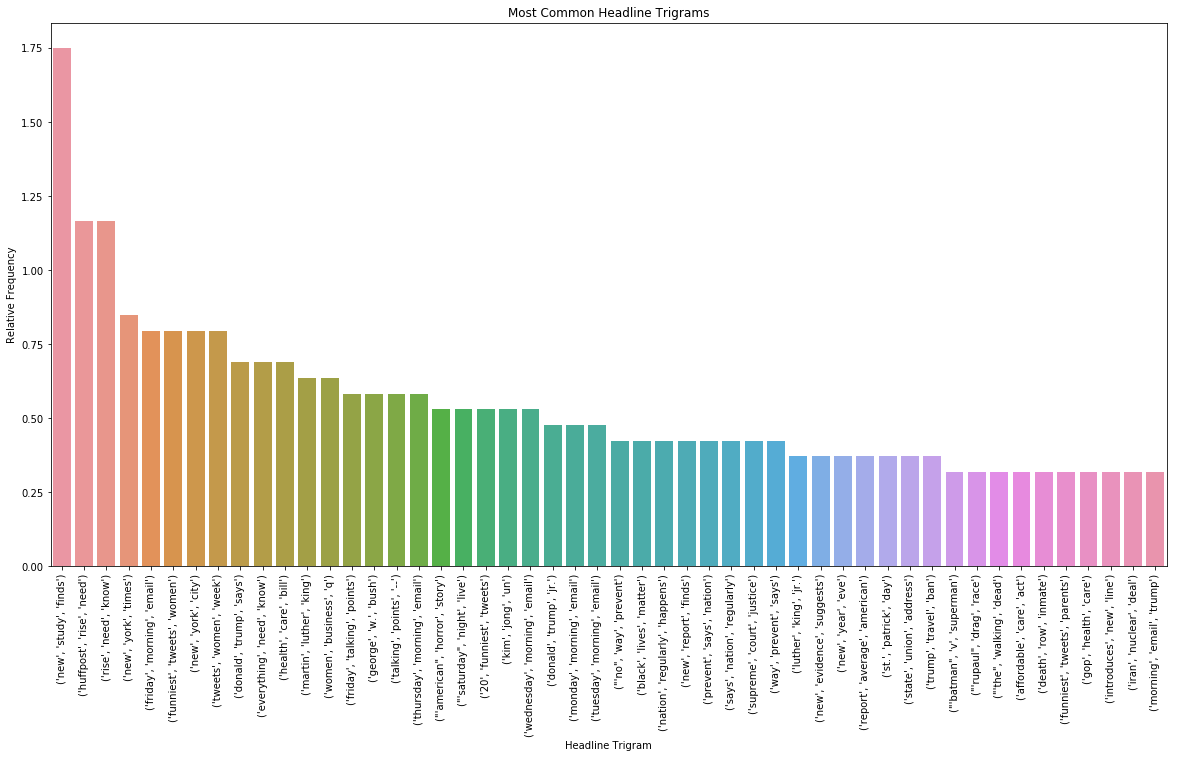

In [149]:
trigrams_tograph = trigrams_df[:50]
plt.figure(figsize=(20,10))
sns.barplot(trigrams_tograph['word'],trigrams_tograph['frequency'])
plt.xlabel('Headline Trigram')
plt.xticks(rotation=90)
plt.ylabel('Relative Frequency')
plt.title('Most Common Headline Trigrams')
plt.show()

**Key differences from and additions to the most common bigrams in all headlines:**
- Headlines associated with the bigram "new york" may actually be more often associated with The New York Times, although "new york city" is also wpresent within our top 10 trigrams.
- "martin luther king" and "george w. bush" are the two key political/historical figures that appear frequently but were not present in our bigrams due to the structure of their names.
- "american horror story", "saturday night live", "st patrick day", "batman v superman", "rupaul drag race", and "the walking dead" are significant, frequent pop culture references that appear as trigrams.
- "health care bill", "black lives matter", "affordable care act", "death row inmate", and "iran nuclear deal" additionally show up freqently as key social issues in our recent news headlines. 

In [150]:
sarc_headline_finder_tri = TrigramCollocationFinder.from_words(all_sarc_words_stopped)
sarc_headline_scored_tri = sarc_headline_finder_tri.score_ngrams(trigram_measures.raw_freq)
sarc_headline_scored_tri[:50]

[(('new', 'study', 'finds'), 0.0003801142646516771),
 (("'no", 'way', 'prevent'), 9.214891264283081e-05),
 (('nation', 'regularly', 'happens'), 9.214891264283081e-05),
 (('new', 'report', 'finds'), 9.214891264283081e-05),
 (('prevent', 'says', 'nation'), 9.214891264283081e-05),
 (('says', 'nation', 'regularly'), 9.214891264283081e-05),
 (('way', 'prevent', 'says'), 9.214891264283081e-05),
 (('new', 'evidence', 'suggests'), 8.063029856247697e-05),
 (('report', 'average', 'american'), 8.063029856247697e-05),
 (('introduces', 'new', 'line'), 6.911168448212312e-05),
 (('secret', 'service', 'agent'), 6.911168448212312e-05),
 (('study', 'finds', 'americans'), 6.911168448212312e-05),
 (('study', 'finds', 'humans'), 6.911168448212312e-05),
 (('study', 'finds', 'majority'), 6.911168448212312e-05),
 (('world', 'wildlife', 'fund'), 6.911168448212312e-05),
 (("'new", 'york', 'times'), 5.759307040176926e-05),
 (('ca', 'wait', 'get'), 5.759307040176926e-05),
 (('dreams', 'one', 'day'), 5.75930704017

In [151]:
sarc_trigrams_df = pd.DataFrame(sarc_headline_scored_tri, columns=['word','frequency'])
sarc_trigrams_df.frequency = sarc_trigrams_df.frequency*10000
sarc_trigrams_df.head()

,word,frequency
0,"(new, study, finds)",3.801143
1,"('no, way, prevent)",0.921489
2,"(nation, regularly, happens)",0.921489
3,"(new, report, finds)",0.921489
4,"(prevent, says, nation)",0.921489


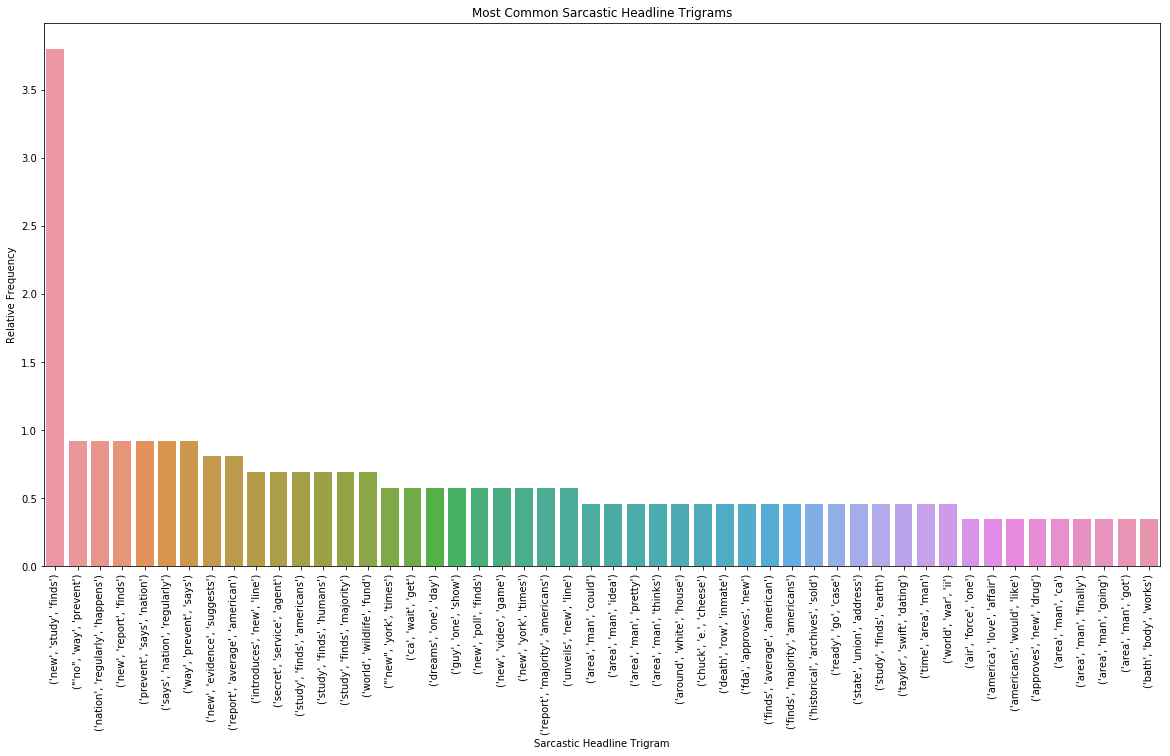

In [152]:
sarc_trigrams_tograph = sarc_trigrams_df[:50]
plt.figure(figsize=(20,10))
sns.barplot(sarc_trigrams_tograph['word'],sarc_trigrams_tograph['frequency'])
plt.xlabel('Sarcastic Headline Trigram')
plt.xticks(rotation=90)
plt.ylabel('Relative Frequency')
plt.title('Most Common Sarcastic Headline Trigrams')
plt.show()

**Key differences from and additions to the most common bigrams in sarcastic headlines:**
- Many of the trigrams indicated trends with regards to common satrical tropes that we observed above, just in different combinations given the additional word. Some examples include "new study finds", "nation regularly happens", "new report finds", "report average american", and "area man thinks", among many others!
- "world wildlife fund", "new york times", "secret service agent", "chuck e. cheese", "death row inmate", "taylor swift dating", "world war ii", and "bath body works" appear as frequent subjects of satirical articles. They may be relatively meaningless within the world of real news, but make great subjects for sarcasm, due to their relatability and commonly-known reputations throughout society.

In [153]:
nonsarc_headline_finder_tri = TrigramCollocationFinder.from_words(all_nonsarc_words_stopped)
nonsarc_headline_scored_tri = nonsarc_headline_finder_tri.score_ngrams(trigram_measures.raw_freq)
nonsarc_headline_scored_tri[:50]

[(('huffpost', 'rise', 'need'), 0.00021574761451785313),
 (('rise', 'need', 'know'), 0.00021574761451785313),
 (('friday', 'morning', 'email'), 0.00014710064626217257),
 (('funniest', 'tweets', 'women'), 0.00014710064626217257),
 (('tweets', 'women', 'week'), 0.00014710064626217257),
 (('everything', 'need', 'know'), 0.00012748722676054957),
 (('health', 'care', 'bill'), 0.00012748722676054957),
 (('new', 'york', 'city'), 0.00012748722676054957),
 (('women', 'business', 'q'), 0.00011768051700973807),
 (('donald', 'trump', 'says'), 0.00010787380725892656),
 (('friday', 'talking', 'points'), 0.00010787380725892656),
 (('new', 'york', 'times'), 0.00010787380725892656),
 (('talking', 'points', '--'), 0.00010787380725892656),
 (('thursday', 'morning', 'email'), 0.00010787380725892656),
 (("'american", 'horror', 'story'), 9.806709750811505e-05),
 (("'saturday", 'night', 'live'), 9.806709750811505e-05),
 (('20', 'funniest', 'tweets'), 9.806709750811505e-05),
 (('kim', 'jong', 'un'), 9.8067097

In [154]:
nonsarc_trigrams_df = pd.DataFrame(nonsarc_headline_scored_tri, columns=['word','frequency'])
nonsarc_trigrams_df.frequency = nonsarc_trigrams_df.frequency*10000
nonsarc_trigrams_df.head()

,word,frequency
0,"(huffpost, rise, need)",2.157476
1,"(rise, need, know)",2.157476
2,"(friday, morning, email)",1.471006
3,"(funniest, tweets, women)",1.471006
4,"(tweets, women, week)",1.471006


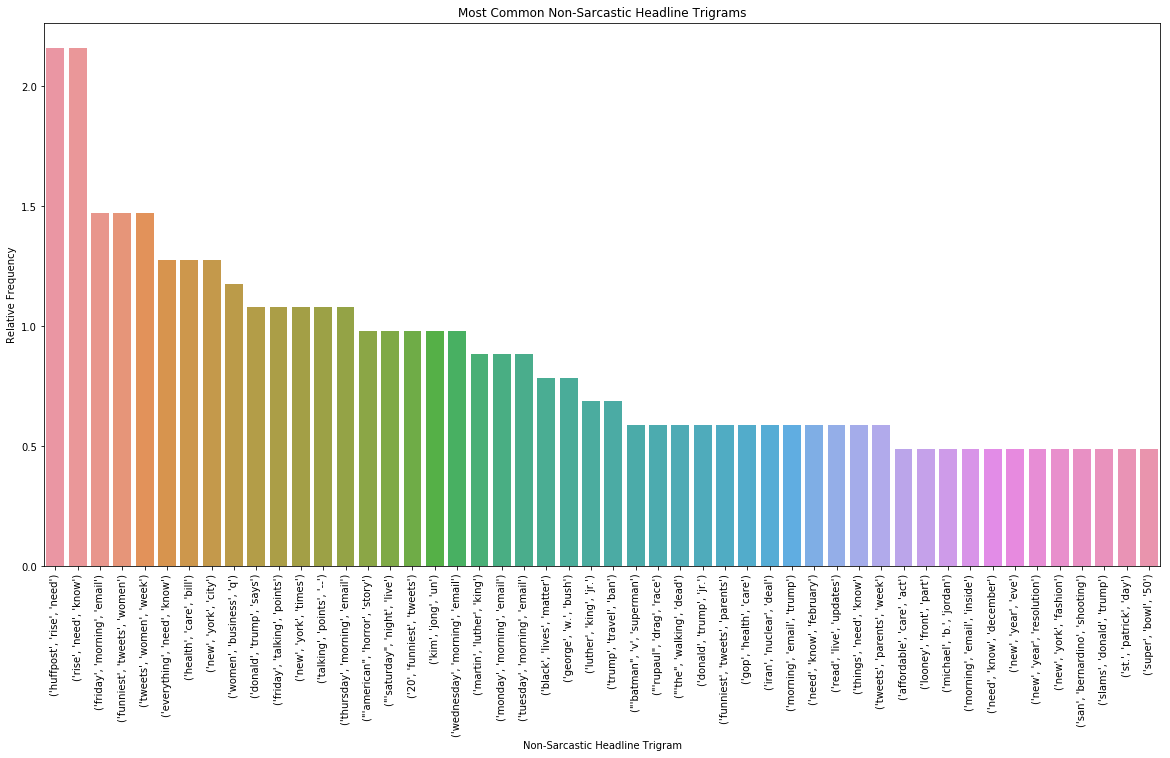

In [155]:
nonsarc_trigrams_tograph = nonsarc_trigrams_df[:50]
plt.figure(figsize=(20,10))
sns.barplot(nonsarc_trigrams_tograph['word'],nonsarc_trigrams_tograph['frequency'])
plt.xlabel('Non-Sarcastic Headline Trigram')
plt.xticks(rotation=90)
plt.ylabel('Relative Frequency')
plt.title('Most Common Non-Sarcastic Headline Trigrams')
plt.show()

**Key differences from and additions to the most common bigrams in non-sarcastic headlines:**
- "michael b. jordan", "san bernardino shooting", "and "new york fashion" appear as additional key topics within our trigrams for real news.
- many of the same trends are present here that we observed in the trigrams for all headlines.

## Modeling the Data

In the following section, we will aim to create the highest-performing classifier than can accurately differentiate between sarcastic and non-sarcastic articles.

### NLP Classification with Word Embeddings

**To create initial classifier models from which to work, we utilized word embeddings in attempts to create word associations based on the GLoVE (Global Vectors for Word Representation) model created by the Stanford NLP Group. As this model has been trained based on massive datasets beyond the scope of our headline data in this project, we are able to draw upon vast amounts of word associations that improve the performance of our Word2Vec models within our relatively small dataset here. Word embeddings allow us to train a neural network that takes into account the semantic meaning between words within the high-dimensional embedding space, based upon their relative positions in the vector space.**

**Once we have created this baseline embedding space, we can apply the word embeddings and their semantic associations to our present dataset. In the following code, we create pipelines that utilize this Word2Vec vectorizer and create optimal (hopefully!) classifiers using decision trees, logistic regression, and support vector machines.**

In [156]:
glove = {}
with open('glove.6B/glove.6B.50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [157]:
glove['school']

array([-0.90629  ,  1.2485   , -0.79692  , -1.4027   , -0.038458 ,
       -0.25177  , -1.2838   , -0.58413  , -0.11179  , -0.56908  ,
       -0.34842  , -0.39626  , -0.0090178, -1.0691   , -0.35368  ,
       -0.052826 , -0.37056  ,  1.0931   , -0.19205  ,  0.44648  ,
        0.45169  ,  0.72104  , -0.61103  ,  0.6315   , -0.49044  ,
       -1.7517   ,  0.055979 , -0.52281  , -1.0248   , -0.89142  ,
        3.0695   ,  0.14483  , -0.13938  , -1.3907   ,  1.2123   ,
        0.40173  ,  0.4171   ,  0.27364  ,  0.98673  ,  0.027599 ,
       -0.8724   , -0.51648  , -0.30662  ,  0.37784  ,  0.016734 ,
        0.23813  ,  0.49411  , -0.56643  , -0.18744  ,  0.62809  ],
      dtype=float32)

In [158]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note from Mike: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # It can't be used in a sklearn Pipeline. 
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

In [159]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ("Random Forest", RandomForestClassifier(n_estimators=100, verbose=True))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ('Support Vector Machine', SVC())])
lr = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
              ('Logistic Regression', LogisticRegression())])

In [160]:
models = [('Random Forest', rf),
          ("Support Vector Machine", svc),
          ("Logistic Regression", lr)]

In [161]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   11.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:   10.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    0.3s finished
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default va

In [162]:
scores

[('Random Forest', 0.7358942562652),
 ('Support Vector Machine', 0.7207683416425245),
 ('Logistic Regression', 0.7087873810569283)]

**As we can see above, all three classifiers created using Word2Vec vectorization preformed very well for initial models! We find above 70% accuracy for all three in predicting whether or not a headline is sarcastic. Moving forward we will aim to create recurrent neural networks that perform with even higher accuracy.**

## Recurrent Neural Networks

**Recurrent neural networks (RNNs) are vital to modeling with NLP because RNNs rely primarily on sequences to make predictions, and the sequence of our words is integral to every language function. Thus, within the structure of a RNN, an output from a given point will be passed into the next point as an input, as each point in our process is dependent on those points around it. Below, we attempt to model our headlines by creating classifiers that differentiate between sarcastic and not-sarcastic utilizing various RNNs.**

### LSTMs and GRUs with Embedding Layers

To start, we create a deep neural network that make use of embedding information similar to that of the previous models. After importing all the necessary packages and processing the data as needed for the models, we create the structure of this DNN below. After the input layer, we add an embedding layer with dimensions corresponding to the specified size of our vocab and the chosen embedding size. Once our data has passed through an embedding layer, we feed this data into a LSTM/GRU layer, followed by a Dense layer, followed by output layer. We also add some Dropout layers after each of these layers, to help fight overfitting.

Once we have designed our model, we still have to compile it, and provide important parameters such as the loss function to use ('binary_crossentropy', since this is a binary classification problem), and the optimizer to use. Following these specifications, we observe a summary of the model and prepare to train/test our network classifier.

Below, we will create both a LSTM and GRU model to see if either performs better than the other, and hopefully, better than our baseline models from before. Both LSTMs and GRUs function by remembering the important information and forgetting anything that it deems irrelevant to the context of the tokens (take the best and leave the rest!). Since neither is necessarily superior to the other, we will test both below and evaluate the results!

In [163]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence

In [164]:
from sklearn.preprocessing import LabelEncoder
Y = df.is_sarcastic
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)
X = df.headline

In [165]:
embedding_size = 128
input_ = Input(shape=(150,))
x = Embedding(20000, embedding_size)(input_)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='softmax')(x)

model = Model(inputs=input_, outputs=x)

In [166]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2)

In [167]:
tokenizer = text.Tokenizer(num_words=20000)
# tokenizer = text.Tokenizer(num_words=1000)
tokenizer.fit_on_texts(list(X_train))
list_tokenized_headlines = tokenizer.texts_to_sequences(X_train)
X_t = sequence.pad_sequences(list_tokenized_headlines, maxlen=150)

In [169]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [170]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 128)          2560000   
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 25)           15400     
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 25)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
__________

In [171]:
model.fit(X_t, Y_train, epochs=2, batch_size=32, validation_split=0.1)

Train on 19230 samples, validate on 2137 samples
Epoch 1/2
19230/19230 [==============================] - 151s 8ms/step - loss: 8.9536 - acc: 0.4384 - val_loss: 8.7582 - val_acc: 0.4506
Epoch 2/2
19230/19230 [==============================] - 130s 7ms/step - loss: 8.9536 - acc: 0.4384 - val_loss: 8.7582 - val_acc: 0.4506


In [172]:
from keras.models import Sequential
import matplotlib.pyplot as plt
%matplotlib inline
from keras.layers import LSTM, GRU, Dense, GlobalMaxPool1D, Embedding, Dropout

In [179]:
gru_model = Sequential()
gru_model.add(Embedding(20000, 128))
gru_model.add(GRU(50, return_sequences=True))
gru_model.add(GlobalMaxPool1D())
gru_model.add(Dropout(0.5))
gru_model.add(Dense(50, activation='relu'))
gru_model.add(Dropout(0.5))
gru_model.add(Dense(1, activation='softmax'))

In [180]:
gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [181]:
gru_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, None, 128)         2560000   
_________________________________________________________________
gru_1 (GRU)                  (None, None, 50)          26850     
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 50)                0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_8 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 51        
Total para

In [182]:
gru_model.fit(X_t, Y_train, epochs=2, batch_size=32, validation_split=0.1)

Train on 19230 samples, validate on 2137 samples
Epoch 1/2
19230/19230 [==============================] - 120s 6ms/step - loss: 8.9536 - acc: 0.4384 - val_loss: 8.7582 - val_acc: 0.4506
Epoch 2/2
19230/19230 [==============================] - 101s 5ms/step - loss: 8.9536 - acc: 0.4384 - val_loss: 8.7582 - val_acc: 0.4506


Based on both models above, neither performs better than the other, and they seem to be relatively ineffective in predicting whether or not headlines are sarcastic, as less thatn 50% of the predictions are correct. Below, we will determine whether another type of RNN model performs better. 

### Bidirectional Sequence Models

One flaw within the RNN models tested above remains their reliance on the forward sequence of data. Sometimes, words may indicate different messages based upon the tokens that follow them, but our prior RNN models cannot see into the future. That's where bidirectional sequence models come in hand! Instead of solely focusing the forward sequence, the model's neurons are split in half, with one group analyzing the forward sequence and the other charting the reverse. Thus, our model can gather a more comprehensive understanding of our text when making predictions, and this allows it to perform much better with more complex language processes such as speech recognition and even sarcasm!

In [183]:
embedding_size = 128
input_ = Input(shape=(150,))
x = Embedding(30000, embedding_size)(input_)
x = Bidirectional(LSTM(25, return_sequences=True))(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_, outputs=x)

In [184]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [185]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 150)               0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 150, 128)          3840000   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 50)           30800     
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dropout_9 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
_________________________________________________________________
dropout_10 (Dropout)         (None, 50)                0         
__________

In [186]:
model.fit(X_t, Y_train, batch_size=32, epochs=5, validation_split=0.1)

Train on 19230 samples, validate on 2137 samples
Epoch 1/5
19230/19230 [==============================] - 169s 9ms/step - loss: 0.4872 - acc: 0.7610 - val_loss: 0.3903 - val_acc: 0.8086
Epoch 2/5
19230/19230 [==============================] - 159s 8ms/step - loss: 0.3766 - acc: 0.8346 - val_loss: 0.3802 - val_acc: 0.8198
Epoch 3/5
19230/19230 [==============================] - 168s 9ms/step - loss: 0.3488 - acc: 0.8469 - val_loss: 0.3698 - val_acc: 0.8208
Epoch 4/5
19230/19230 [==============================] - 185s 10ms/step - loss: 0.3289 - acc: 0.8549 - val_loss: 0.3708 - val_acc: 0.8198
Epoch 5/5
19230/19230 [==============================] - 280s 15ms/step - loss: 0.3101 - acc: 0.8647 - val_loss: 0.3904 - val_acc: 0.8180


In [187]:
list_tokenized_headlines = tokenizer.texts_to_sequences(X_test)
X_tt = sequence.pad_sequences(list_tokenized_headlines, maxlen=150)

In [188]:
accr = model.evaluate(X_tt,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

5342/5342 [==============================] - 14s 3ms/step
Test set
  Loss: 0.404
  Accuracy: 0.823


When we fit, train, and validate our bidirectional sequence model, run on 5 epochs, we achieve accuracy scores of approximately 86% and 82%, for the training set and validation set, respectively. Run on our test set as well, this high level of accuracy is maintained at 82.3%. Thus, our birectional sequence model provides the most effective predictions of sarcasm within headlines.

## Summary

Within our exploration of over 26,000 article headlines, we discovered the following:
- Our dataset was comprised of 43.9% sarcastic articles and 56.1% non-sarcastic articles.
- Across all headlines, there were over 280,000 tokens and over 29,000 unique tokens.
- Trump, Obama, and Clinton were the most mentioned people across all article headlines.
- References to men were 3x as likely as references to women.
- Climate change, health care, sexual assault, and mental health were the top social issues.
- Most of the sarcastic bigrams represent a vague generality that allows the headlines to be more relateable and applicable to a wide variety of people.
- New York and North Korea are the most frequently mentioned places.
- Donald Trump appears in nearly all the top lists of words, bigrams, and trigrams.

When modeling the data, we found:
- Baseline models utilizing Word2Vec vectorization and word embeddings performed well, with over 70% accuracy.
- LSTM and GRU models using RNN structure performed poorly, with under 50% accuracy.
- Our bidirectional sequence model performed the best, with 82.3% accuracy for the test set, after training the model on the train and validation sets.

## Future Work

Future work within this field may involve training models that are able to differentiate between real news and fake news. While the validity and objectivity of news remains a matter of opinion, no matter which way you lean, our media has become more and more subjective and influenced by bias, whether from those biases of the brodcasting network or the ways in which technology employs as usage data to feed us content that further supports our preexisting beliefs. These practices further fortify the political barriers that divide our nation, and thus, measures that aide in the transparency and true objectivity of the state of our government and society will enable us to properly tackle the issues that we face in the 21st century. While our project here scratches the surface of language processing and NLP data management, the possibilities for future work within this arena are endless.